In [1]:
!pip install yfinance nltk vaderSentiment requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import requests

In [5]:
start_date = "2025-05-01"
end_date = datetime.now().strftime('%Y-%m-%d')

nvidia_stock = yf.Ticker('NVDA')
stock_data = nvidia_stock.history(start=start_date, end=end_date)
stock_data.reset_index(inplace=True)
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-05-01 00:00:00-04:00,113.080002,114.940002,111.300003,111.610001,236121500,0.0,0.0
1,2025-05-02 00:00:00-04:00,114.180000,115.400002,113.370003,114.500000,190194800,0.0,0.0
2,2025-05-05 00:00:00-04:00,112.910004,114.669998,112.660004,113.820000,133163200,0.0,0.0
3,2025-05-06 00:00:00-04:00,111.480003,114.739998,110.820000,113.540001,158525600,0.0,0.0
4,2025-05-07 00:00:00-04:00,113.050003,117.680000,112.279999,117.059998,206758800,0.0,0.0


In [7]:
api_key = 'ur_api_key'
url = 'https://newsapi.org/v2/everything'
params = {
    'q':'Nvidia',
    'from':(datetime.now() - timedelta(days=28)).strftime('%Y-%m-%d'),
    'sortBy' : 'relevancy',
    'apiKey' :api_key,
    'pageSize' : 100,
    'language':'en'
}
response = requests.get(url, params=params)
data = response.json()
if data['status'] != 'ok':
    raise Exception(f"NewsAPI error: {data['message']}")

articles = data['articles']
news_data = pd.DataFrame(articles)
news_data = news_data[['publishedAt', 'title']]
news_data.columns = ['date', 'headline']


In [8]:
data

{'status': 'ok',
 'totalResults': 8920,
 'articles': [{'source': {'id': 'the-verge', 'name': 'The Verge'},
   'author': 'Jess Weatherbed',
   'title': 'Nvidia’s flattery of Trump wins reversal of AI chip limits and a Huawei clampdown',
   'description': 'Nvidia’s efforts to suck up to the Trump administration have seemingly paid off, with the US now lifting export limits on US-made AI chips and cracking down on anyone using Huawei’s emerging alternatives. The announcements come as Nvidia CEO Jensen Huang join…',
   'url': 'https://www.theverge.com/news/666605/nvidias-flattery-of-trump-wins-reversal-of-ai-chip-limits-and-a-huawei-clampdown',
   'urlToImage': 'https://platform.theverge.com/wp-content/uploads/sites/2/2025/05/gettyimages-2214285765.jpg?quality=90&strip=all&crop=32.4%2C38.277472621363%2C57.866662597656%2C45.445057137646&w=1200',
   'publishedAt': '2025-05-14T10:40:56Z',
   'content': 'Trump (center) and Jensen Huang (lower level, far right) seen posing with the Saudi royal 

In [9]:
news_data

,date,headline
0,2025-05-14T10:40:56Z,Nvidia’s flattery of Trump wins reversal of AI...
1,2025-05-14T17:51:34Z,Switch 2 spec breakdown digs into its processo...
2,2025-05-15T21:08:02Z,The Middle East Has Entered the AI Group Chat
3,2025-05-29T08:50:44Z,Tested: Nvidia’s GeForce Now just breathed new...
4,2025-06-04T02:09:51Z,Nvidia dethrones Microsoft as the world's most...
...,...,...
95,2025-05-19T13:57:16Z,Nvidia sets up shop in Taiwan with AI supers a...
96,2025-05-21T03:27:11Z,Nvidia CEO Jensen Huang labels US GPU export b...
97,2025-05-20T01:00:34Z,Computex 2025: All the Weird and Wacky Gadgets...
98,2025-05-15T21:47:41Z,Slay in style with RTX 50-series DOOM: The Dar...


In [10]:
#NLP Sentiment Analysis
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

def preprocess_text(text):
  words = word_tokenize(text)
  words = [word for word in words if word.isalpha()]
  words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(words)

news_data['cleaned_headline'] = news_data['headline'].apply(preprocess_text)

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

news_data['sentiment_score'] = news_data['cleaned_headline'].apply(get_sentiment_score)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
news_data

,date,headline,cleaned_headline,sentiment_score
0,2025-05-14T10:40:56Z,Nvidia’s flattery of Trump wins reversal of AI...,Nvidia flattery Trump wins reversal AI chip li...,0.6249
1,2025-05-14T17:51:34Z,Switch 2 spec breakdown digs into its processo...,Switch spec breakdown digs processor GameChat,0.0000
2,2025-05-15T21:08:02Z,The Middle East Has Entered the AI Group Chat,Middle East Entered AI Group Chat,0.0000
3,2025-05-29T08:50:44Z,Tested: Nvidia’s GeForce Now just breathed new...,Tested Nvidia GeForce breathed new life Steam ...,0.0000
4,2025-06-04T02:09:51Z,Nvidia dethrones Microsoft as the world's most...,Nvidia dethrones Microsoft world valuable publ...,0.4767
...,...,...,...,...
95,2025-05-19T13:57:16Z,Nvidia sets up shop in Taiwan with AI supers a...,Nvidia sets shop Taiwan AI supers factory full...,0.0000
96,2025-05-21T03:27:11Z,Nvidia CEO Jensen Huang labels US GPU export b...,Nvidia CEO Jensen Huang labels US GPU export b...,-0.7506
97,2025-05-20T01:00:34Z,Computex 2025: All the Weird and Wacky Gadgets...,Computex Weird Wacky Gadgets Hitting Scene,-0.1779
98,2025-05-15T21:47:41Z,Slay in style with RTX 50-series DOOM: The Dar...,Slay style RTX DOOM Dark Ages PCs laptops GPUs...,-0.0343


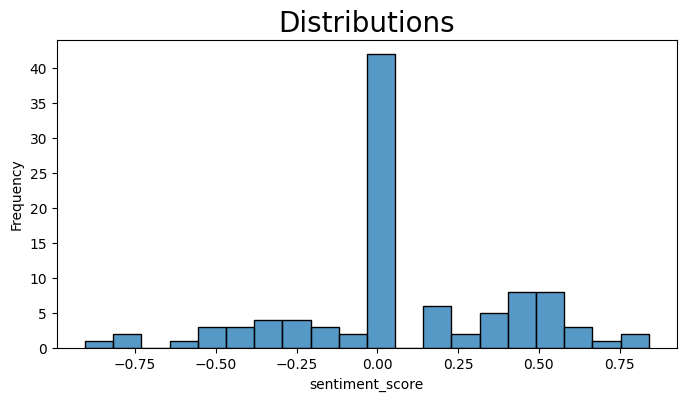

In [13]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.histplot(news_data['sentiment_score'], bins=20)
plt.title('Distributions', fontsize=20)
plt.xlabel('sentiment_score')
plt.ylabel('Frequency')
plt.show()

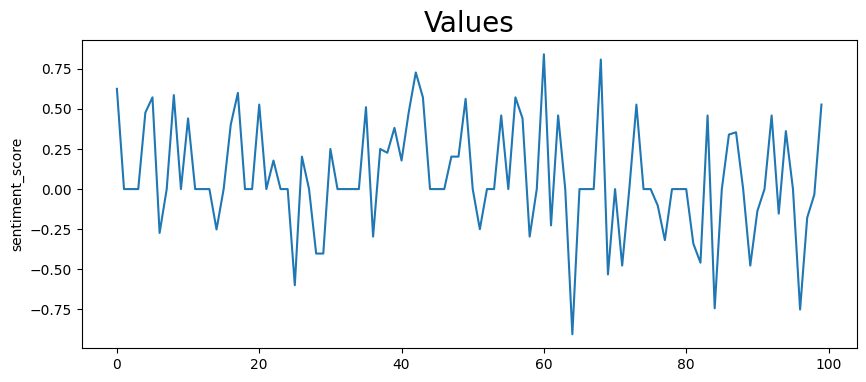

In [15]:
plt.figure(figsize=(10, 4))
news_data['sentiment_score'].plot()
plt.title('Values', fontsize=20)
plt.ylabel('sentiment_score')
plt.show()

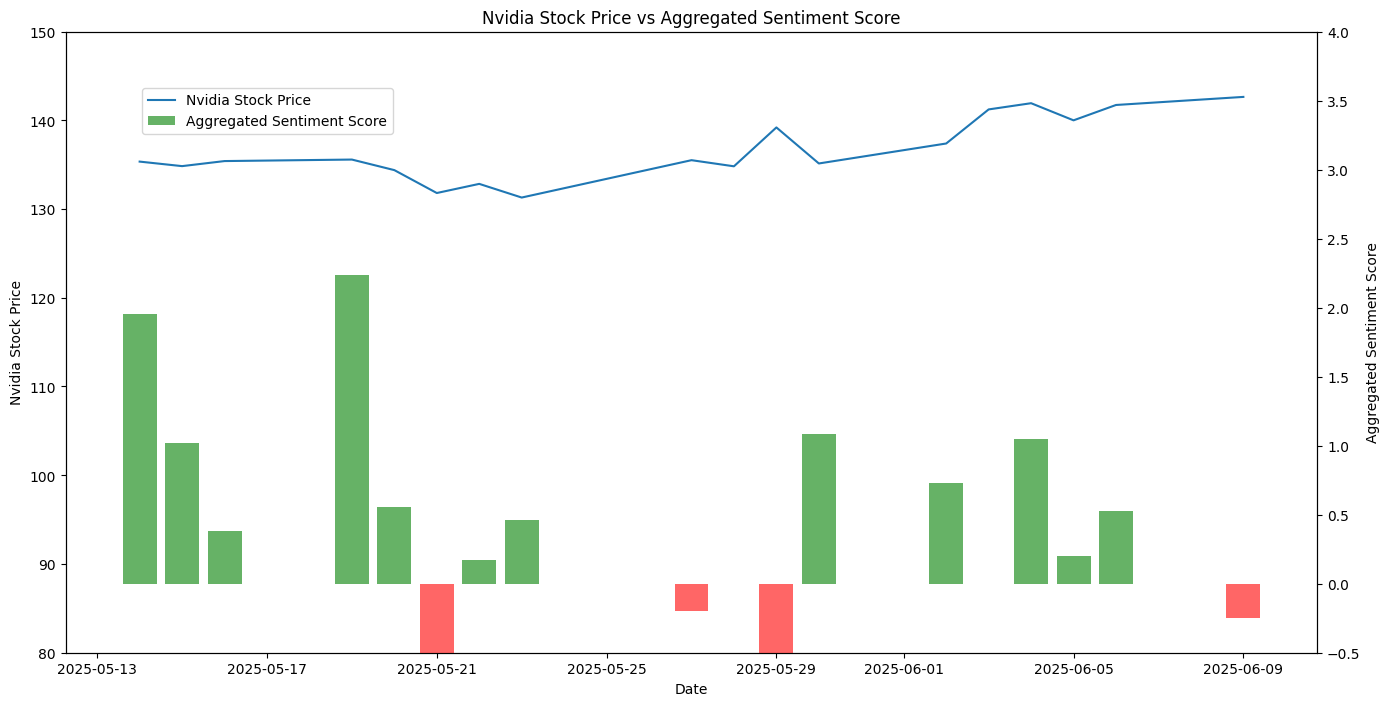

In [17]:


analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

news_data['sentiment_score'] = news_data['cleaned_headline'].apply(get_sentiment_score)

news_data['date'] = pd.to_datetime(news_data['date']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

aggregated_sentiment = news_data.groupby('date')['sentiment_score'].sum().reset_index()

combined_data = pd.merge(stock_data, aggregated_sentiment, left_on='Date', right_on='date', how='inner')

# Visualize the data with a secondary y-axis and bar plot for aggregated sentiment scores
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Nvidia Stock Price')
ax1.plot(combined_data['Date'], combined_data['Close'], label='Nvidia Stock Price')
ax1.tick_params(axis='y')
ax1.set_ylim(80, 150)

ax2 = ax1.twinx()
ax2.set_ylabel('Aggregated Sentiment Score')

colors = ['green' if val >= 0 else 'red' for val in combined_data['sentiment_score']]
ax2.bar(combined_data['Date'], combined_data['sentiment_score'], label='Aggregated Sentiment Score', color=colors, alpha=0.6)
ax2.tick_params(axis='y')
ax2.set_ylim(-0.5, 4)

fig.tight_layout()
plt.title('Nvidia Stock Price vs Aggregated Sentiment Score')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()